### Anomaly detection in Oklahoma purchase credit card transactions by neural network

### Author: Huizhe (Sunny) Zhu- hz2657

The Office of Management and Enterprise Services in the State of Oklahoma has made its [purchase credit card transactions](https://catalog.data.gov/dataset/purchase-card-pcard-fiscal-year-2014) available. This dataset contains information on purchases made through the purchase card programs administered by the state and higher education institutions. 

Goal:

Use Autoencoder and iForest algorithms in PyOD to apply to the dataset in order to find abnormal transactions.


## 1. load data, construct features

In [11]:
# load packages
import numpy as np
import pandas as pd
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN

Using TensorFlow backend.


In [3]:
# 1. load data
import pandas as pd
df = pd.read_csv(r'purchase_credit_card.csv', encoding = "ISO-8859-1")   

# change column names 
df.columns = ['Year_Month', 'Agency_Number', 'Agency_Name', 'Cardholder_Last_Name',
      'Cardholder_First_Initial', 'Description', 'Amount', 'Vendor', 'Transaction_Date',
      'Posted_Date', 'Merchant_Category']
df.head(2)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,7/30/2013 0:00,7/31/2013 0:00,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,7/30/2013 0:00,7/31/2013 0:00,SHERATON


In [4]:
# 2. Create timestamp, "time" variable
df['Transaction_Date'] = pd.to_datetime(df.Transaction_Date, format="%m/%d/%Y %H:%M") 

# create "time" variable: days since last purchase 
df = df.sort_values(['Agency_Name', 'Transaction_Date'], ascending=[True, True])
df['time'] = df.Transaction_Date-df.Transaction_Date.shift(1)

# convert days to numeric 
df['time'] = df['time'] / pd.Timedelta(1, unit='d')

# convert negative values to 0
df.loc[(df.time < 0 ),'time'] = 0 

In [5]:
# 3. construct features
# Feature 1: Ratio of amount spend and average spending by agency and merchant category
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category'])['Amount'].mean()
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['AVG_amount']
df2 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category'])
df2['ratio_amount_by_agency_by_category'] = df2.Amount / df2.AVG_amount

# Feature 2: Ratio of amount spend and average spending by agency and transaction description
stat_by_Description = df.groupby(['Agency_Name', 'Description'])['Amount'].mean()
stat_by_Description = pd.DataFrame(stat_by_Description)
stat_by_Description.columns = ['AVG_amount_by_Description']
df2 = pd.merge(df2, stat_by_Description, how='left', on=['Agency_Name', 'Description'])
df2['ratio_amount_by_agency_by_Description'] = df2.Amount / df2.AVG_amount_by_Description

# Feature 3: Ratio of amount spend and average spending by card holder
stat_by_cardholder = df2.groupby(['Agency_Name', 'Cardholder_Last_Name'])['Amount'].mean()
stat_by_cardholder = pd.DataFrame(stat_by_cardholder)
stat_by_cardholder.columns = ['stat_by_cardholder']
df2 = pd.merge(df2, stat_by_cardholder, how='left', on=['Agency_Name', 'Cardholder_Last_Name'])
df2['ratio_amount_by_cardholder'] = df2.Amount / df2.stat_by_cardholder

# Feature 4: ratio of time since last purchase / average time spend
AVG_time_since_lastP = df2.groupby(['Agency_Name'])['time'].sum()/ df2.groupby(['Agency_Name'])['time'].count()
AVG_time_since_lastP = pd.DataFrame(AVG_time_since_lastP)
AVG_time_since_lastP.columns = ['AVG_time_since_lastP']
df2 = pd.merge(df2, AVG_time_since_lastP, how='left', on=['Agency_Name'])
df2['Ratio_AVG_time_since_lastP']=df2.time/df2.AVG_time_since_lastP

# Feature 5: ratio of time / average time spend since last transactions by card holder
AVG_time_since_lastP_by_cardholder  = df2.groupby(['Agency_Name', 'Cardholder_Last_Name'])['time'].sum()/ df2.groupby(['Agency_Name','Cardholder_Last_Name'])['time'].count()
AVG_time_since_lastP_by_cardholder = pd.DataFrame(AVG_time_since_lastP_by_cardholder)
AVG_time_since_lastP_by_cardholder.columns = ['AVG_time_since_lastP_by_cardholder']
df2 = pd.merge(df2, AVG_time_since_lastP_by_cardholder, how='left', on=['Agency_Name','Cardholder_Last_Name'])
df2['Ratio_AVG_time_since_lastP_by_cardholder']= df2.time/df2.AVG_time_since_lastP_by_cardholder

In [13]:
# Standardization
# for unsupervised learning, it is always a safe step to standardize the predictors
df3 = df2.loc[:, ['ratio_amount_by_agency_by_category', 
                  'ratio_amount_by_agency_by_Description',
                   'ratio_amount_by_cardholder',  
                  'Ratio_AVG_time_since_lastP',  
                  'Ratio_AVG_time_since_lastP_by_cardholder'
                 ]]

# replace na with 1: ratio = 1 means no specific meaning
df3.replace(np.nan, 1,inplace=True)

# replace inf and -inf with 1
df3.replace(np.inf, 1,inplace=True)
df3.replace(-np.inf, 1,inplace=True)

# standardize
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(df3)

In [39]:
# split into train and test dataset
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X_std, test_size=0.5, random_state=42)

## 2. Build Models

## Section 1: Autoencoder

- Autoencoder is a special type of neural network that uses the same data as both the input values and output values. The goal is to get the middle layer which reduces noises, it can also be considered as a method of dimension reduction. 

- Autoencoder uses non-linear transformation, if there are too many hidden layers or too many neutrons, the model tends to overfit; otherwise the model tends to underfit.

- Applications of autoencoder include image noise reduction and image coloring. 


### 2.1.1 Build model

In [124]:
#### Model 1: clf1 has hidden_neurons = [5, 2, 2, 5]
AutoEncoder_model = AutoEncoder(hidden_neurons =[5, 2, 2, 5])
AutoEncoder_model.fit(X_train)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 5)                 30        
_________________________________________________________________
dropout_13 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 30        
_________________________________________________________________
dropout_14 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 30        
_________________________________________________________________
dropout_15 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[5, 2, 2, 5],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x000001AFB27E84C8>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [125]:
# raw outlier scores from model 1 
AutoEncoder_y_train_scores = AutoEncoder_model.decision_scores_ 

# get the prediction on the test data
AutoEncoder_y_test_pred = AutoEncoder_model.predict(X_test)  # outlier labels (0 or 1)

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
AutoEncoder_y_test_scores = AutoEncoder_model.decision_function(X_test)  # outlier scores

AutoEncoder_y_test_pred = pd.Series(AutoEncoder_y_test_pred)
AutoEncoder_y_test_scores = pd.Series(AutoEncoder_y_test_scores)

In [126]:
AutoEncoder_y_test_pred.value_counts()

0    199163
1     22066
dtype: int64

### 2.1.2 Set boundary and identify outliers

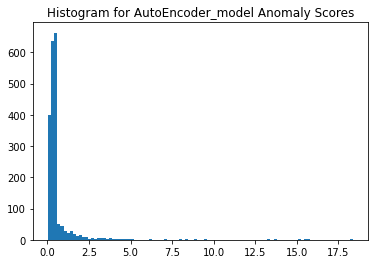

In [129]:
# Histogram for Model Clf1 Anomaly Scores
import matplotlib.pyplot as plt
plt.hist(AutoEncoder_y_test_scores[1:2000], bins=100)  # arguments are passed to np.histogram
plt.title("Histogram for AutoEncoder_model Anomaly Scores")
plt.show()

From the graph, we can see the observations above 5 are extreme cases, we will set the boundary to be 5. We identified anomalous cases: 
- 2205 observations
- 9.6%  of total observations

In [130]:
# set boundary: 5 
# identify outliers in cluster 1
X_test = pd.DataFrame(X_test)
df_test = X_test.copy()
df_test['score'] = AutoEncoder_y_test_scores
df_test['cluster'] = np.where(df_test['score']<5, 0, 1)
df_test['cluster'].value_counts()

0    219132
1      2097
Name: cluster, dtype: int64

In [131]:
# percentage of outliers: 9.6% 
2097/218081

0.009615693251590006

### 2.1.3 Describe the outliers, get summary statistics by cluster
* We recommend observations in Cluster 1 to be outliers. 
* The attributes of Cluster 1 are shown below.

In [132]:
# summary statistics
df_test.columns = ['ratio_amount_by_agency_by_category', 
                  'ratio_amount_by_agency_by_Description',
                   'ratio_amount_by_cardholder',  
                  'Ratio_AVG_time_since_lastP',  
                  'Ratio_AVG_time_since_lastP_by_cardholder', 
                   'anomaly scores', 'cluster']
df_test.groupby('cluster').mean()

,ratio_amount_by_agency_by_category,ratio_amount_by_agency_by_Description,ratio_amount_by_cardholder,Ratio_AVG_time_since_lastP,Ratio_AVG_time_since_lastP_by_cardholder,anomaly scores
cluster,,,,,,
0,-1.145794e-16,-2.446088e-16,-0.041776,-0.034260,-0.043593,0.518990
1,7.244189e-03,1.234511e-01,4.232221,3.614706,4.558975,12.733886


### 2.1.4 business insights 

- 9.6% outliers are identified. 
- Autoencoder has similar result with KNN. The outliers have higher spending and more time since last purchase compared compared with average level. It distinguishes the transactions that happen less frequent than usual and have higher spending. 
- It is possible that the card is stolen or lost, then being used again with more money each transaction. 

## Section 2: iForest

- Isolated Forest is a method to separate trees utill all are isolated and find which tree is the easiest to be seperated. An outlier is the easiest to be isolated. 

- iTree algorithm is different from the decision tree algorithm because iTree does not use a target variable to train the tree. It is an unsupervised learning method. 

- If there are 1,000 subsets, there will be 1,000 iTrees. Each data point in an iTree will have an anomaly score. Because there are 1,000 iTrees, each data point will have multiple anomaly scores. The average (arithmetic mean) score for a data point across all the iTrees becomes the anomaly score for that data point.

### 2.2.1 Build model

In [108]:
from pyod.models.iforest import IForest

#  Model 1: max_samples = 60
clf1 = IForest(behaviour="new", max_samples=60) 
clf1.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=60, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [109]:
# Predict raw anomaly score of X using the fitted detector.
# get anomaly scores: 
clf1_y_test_scores = clf1.decision_function(X_test)  # outlier scores
clf1_y_test_scores = pd.Series(y_test_scores)
clf1_y_test_scores.head()

0   -0.118434
1   -0.091982
2   -0.193658
3   -0.185776
4   -0.179198
dtype: float64

### 2.2.2 Set boundary and identify outliers

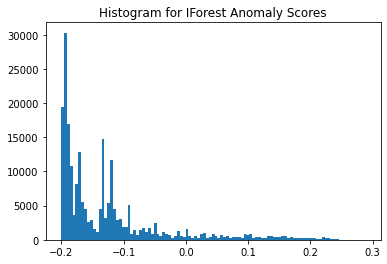

In [110]:
# Histogram of anomaly scores
import matplotlib.pyplot as plt
plt.hist(clf1_y_test_scores, bins=105) 
plt.title("Histogram for IForest Anomaly Scores")
plt.show()

# from the graph, we identify the boundary to be: 0.05  [need to be changed, so is the code in next cell]

From the graph, we can see most observations are on the left of 0. The observations above 0.2 are extreme cases, we will set the boundary to be 0.2. We got 2205 observations as outliers, they account for 1.01% of total observations

In [112]:
X_test_cluster = X_test.copy()
X_test_cluster['distance'] = clf1_y_test_scores
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']<0.2, 0, 1)
X_test_cluster['cluster'].value_counts()

0    219024
1      2205
Name: cluster, dtype: int64

In [74]:
# show percentage of outliers
2205/219024

0.010067389875082183

### 2.2.3 Describe the outliers, get summary statistics by cluster

In [88]:
# summary statistics 
X_test_cluster.columns = ['ratio_amount_by_agency_by_category', 
                  'ratio_amount_by_agency_by_Description',
                   'ratio_amount_by_cardholder',  
                  'Ratio_AVG_time_since_lastP',  
                  'Ratio_AVG_time_since_lastP_by_cardholder', 
                   'distance', 'cluster']

X_test_cluster.groupby('cluster').mean()

,ratio_amount_by_agency_by_category,ratio_amount_by_agency_by_Description,ratio_amount_by_cardholder,Ratio_AVG_time_since_lastP,Ratio_AVG_time_since_lastP_by_cardholder,distance
cluster,,,,,,
0,6.935799e-05,1.181957e-03,-0.006190,-0.042388,-0.056681,-0.129635
1,1.228787e-15,3.068525e-15,0.488076,4.243346,5.633590,0.222902


### 2.2.4 Business insights 

- 1.1% of total transactions are identified to be outliers. 
- Compared with Autoencoder, Iforest have slightly different patterns. From the table, we can see compared to cluster 0, cluster 1 has more spending and it takes more time for this transaction to happen on cardholder level. However, the ratios on agency level for amount spend by category and description have different patterns.
- Insights: Outliers have more spending on cardholder level and takes more time for this transaction to happen. It is possible that the card for that cardholder is stolen or lost, then being used again. 


## 3. Summary

- Autoencoder has very similar results to KNN, the average ratios in outlier's group is higher than the rest of the observations. 

- iforest is slightly different compared with Autoencoder and KNN, it identifies outliers that have more spending and take more time for this transaction to happen on cardholder level but not agent level. 

- But in general, Autoencoder and Iforest identify similar pattern of outliers, with higher spending compared with average level, and more time since last purchase.  